In [ ]:
from scipy.stats import norm
import numpy as np
from stochoptim.scengen.scenario_tree import ScenarioTree
from stochoptim.scengen.scenario_process import ScenarioProcess
from stochoptim.scengen.variability_process import VariabilityProcess 
from stochoptim.scengen.figure_of_demerit import FigureOfDemerit 

We illustrate on a Geometric Brownian Motion (GBM) the second of the two methods to build scenario trees with **optimized scenarios and structure**.  

This method does not explore the space of tree structures, it builds the structure 'forward' stage-by-stage by meeting a `width_vector` requirement (either given explicity or calculated optimally). It has the advantage to be practical even when the number of stages and scenarios is large. However, it does not offer the diversity of structures that the other method does.

# Define a `ScenarioProcess` instance for the GBM

In [2]:
S_0 = 2 # initial value (at stage 0)
delta_t = 1 # time lag between 2 stages
mu = 0 # drift
sigma = 1 # volatility

The `gbm_recurrence` function below implements the dynamic relation of a GBM:  
* $S_{t} = S_{t-1} \exp[(\mu - \sigma^2/2) \Delta t + \sigma  \epsilon_t\sqrt{\Delta t}], \quad t=1,2,\dots$  

where $\epsilon_t$ is a standard normal random variable $N(0,1)$.

The discretization of $\epsilon_t$ is done by quasi-Monte Carlo (QMC) and is implemented by the `epsilon_sample_qmc` method.

In [3]:
def gbm_recurrence(stage, epsilon, scenario_path):
    if stage == 0:
        return {'S': np.array([S_0])}
    else:
        return {'S': scenario_path[stage-1]['S'] \
                        * np.exp((mu - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon)}
    
def epsilon_sample_qmc(n_samples, stage, u=0.5):
    return norm.ppf(np.linspace(0, 1-1/n_samples, n_samples) + u / n_samples).reshape(-1, 1)

scenario_process = ScenarioProcess(gbm_recurrence, epsilon_sample_qmc)

# Define a `VariabilityProcess` instance

In [4]:
def lookback_fct(stage, scenario_path):
    return scenario_path[stage]['S'][0] + 1

my_variability = VariabilityProcess(lookback_fct)

# Forward generation of structure

### From a given `width_vector`

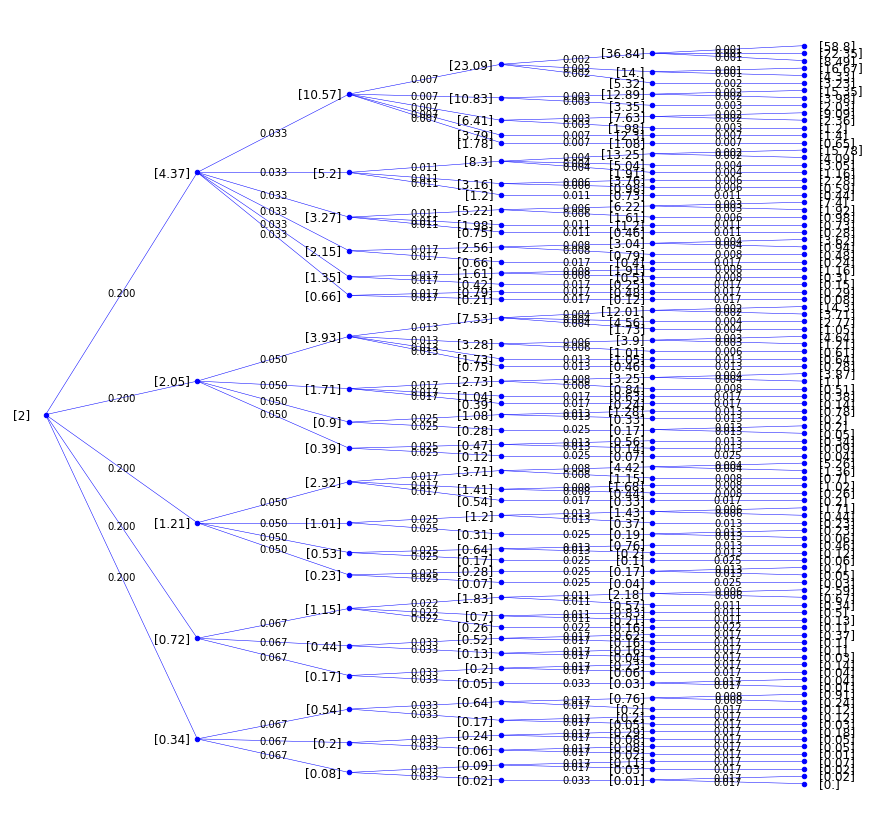

In [5]:
scen_tree = ScenarioTree.forward_generation_from_given_width(width_vector=[5,20,50,80,100],
                                                             scenario_process=scenario_process, 
                                                             variability_process=my_variability, 
                                                             alpha=1)
scen_tree.plot(var_name='S', figsize=(15,15))

### Without a `width_vector`

In [6]:
def lookback_fct(stage, scenario_path):
    return scenario_path[stage]['S'][0] + 1

def looknow_fct(stage, epsilon):
    return np.exp(epsilon[0])

def average_fct(stage):
    return 1

my_variability = VariabilityProcess(lookback_fct, looknow_fct, average_fct)

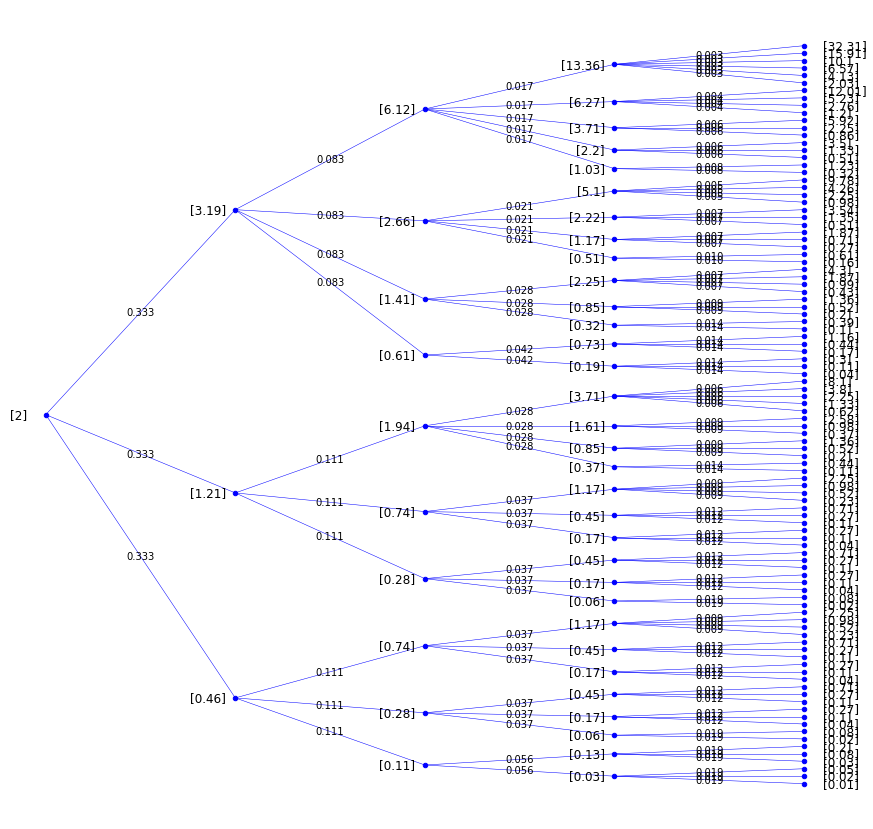

In [7]:
scen_tree = ScenarioTree.forward_generation(n_stages=5,
                                            n_scenarios=100,
                                            scenario_process=scenario_process, 
                                            variability_process=my_variability, 
                                            alpha=1)
scen_tree.plot(var_name='S', figsize=(15,15))